In [1]:
import glob
import os
import cv2
import numpy as np
import segmentation_models_pytorch as smp
import torch
import albumentations as A
import json
import time

from dataloaders import TacoLoaders
from segmentation_models_pytorch import utils
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from utils import *
from pycocotools.coco import COCO
from torch.utils.data import Dataset, DataLoader
from utils import visualize

In [2]:
def get_training_augmentation():
    transform = [
        A.HorizontalFlip(p=0.5), 
        A.RandomCrop(height=512, width=512, p=1),
        A.Perspective(p=0.5),
#       A.GaussNoise (p=0.1),  
#       A.ShiftScaleRotate(scale_limit=0.1, 
#                             rotate_limit=10, 
#                             shift_limit=0.2, 
#                             p=1, 
#                             border_mode=0),
#         
        
    ]
    return A.Compose(transform)

In [3]:
ENCODER = 'efficientnet-b2'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'softmax2d'
DEVICE = 'cuda'
NUM_CLASSES = 2

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)
loss = smp.utils.losses.JaccardLoss()

metrics = [
    smp.utils.metrics.IoU(activation = None),
]

In [4]:
class My_network():
    
    
    def __init__(self, loss, metrics, lr=0.00001):
        self.model = smp.DeepLabV3Plus(
            encoder_name=ENCODER, 
            encoder_weights=ENCODER_WEIGHTS, 
            classes=NUM_CLASSES, 
            activation=ACTIVATION,
        )
        self.optimizer = torch.optim.Adam([ 
            dict(params=self.model.parameters(), lr=lr),
        ])
        
        self.train_epoch = smp.utils.train.TrainEpoch(
            self.model, 
            loss=loss, 
            metrics=metrics, 
            optimizer= self.optimizer,
            device=DEVICE,
            verbose=True,
        )

        self.valid_epoch = smp.utils.train.ValidEpoch(
            self.model, 
            loss=loss, 
            metrics=metrics, 
            device=DEVICE,
            verbose=False,
        )
        
        
    def run_training(self, loaders, n_epochs=40, save_name='./output/best_model.pth'):
        max_score = 0
        for i in range(0, n_epochs):
            
            train_logs = self.train_epoch.run(loaders.train_loader)
            valid_logs = self.valid_epoch.run(loaders.valid_loader)

            if max_score < valid_logs['iou_score']:
                max_score = valid_logs['iou_score']
                torch.save(self.model, save_name)
            
#             if i%5==0: 
#                 print(f'==Epoch {i}==')
#                 print('Train/Val IoU:')
#                 print(round(train_logs['iou_score'] , 4))
#                 print(round(valid_logs['iou_score'] , 4))
    
    def eval(self, dataloader, model_path='./output/best_model.pth'):
        best_model = torch.load(model_path)
        test_epoch = smp.utils.train.ValidEpoch(
                         model=best_model,
                         loss=loss,
                         metrics=metrics,
                         device=DEVICE,
                         verbose=True
                      )

        logs = test_epoch.run(dataloader)
        return best_model

In [5]:
network = My_network(loss, metrics)

In [6]:
taco_loaders = TacoLoaders(batch_size=16,
                           augmentation=get_training_augmentation(),
                           preprocessing_fn=preprocessing_fn,)

1200 150 150


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Example image and mask:


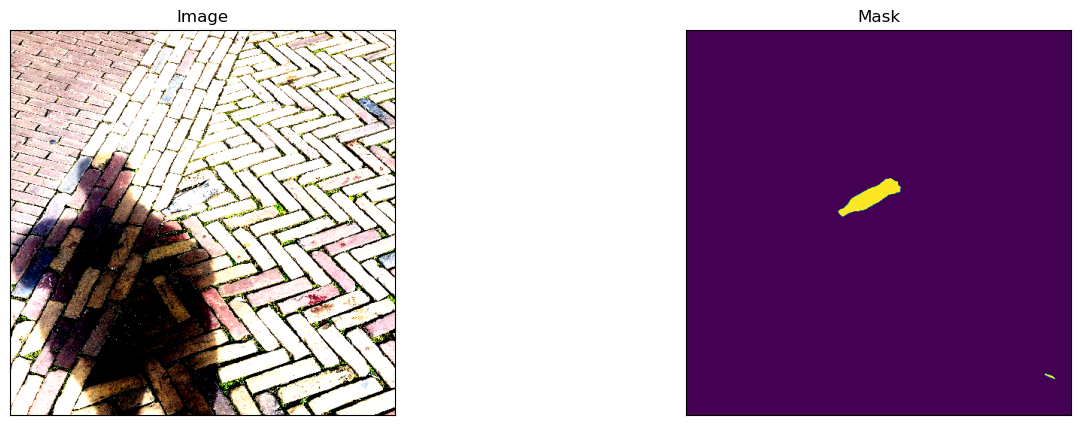

In [7]:
print("Example image and mask:")
taco_loaders.show_example()

In [ ]:
print("Training model:")
network.run_training(taco_loaders, n_epochs=1000)

In [ ]:
print("Eval model:")
best_model = network.eval(taco_loaders.test_loader)
compare_predictions(taco_loaders, best_model)